## Imports

In [1]:
import torch
from torch.utils.data import DataLoader

import torchvision
import torch.nn.functional as F
from torchvision import transforms

import matplotlib.pyplot as plt

import cv2

## Load the training data

In [3]:
train_tn = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transforms.ToTensor(), download=True)
train_ld = DataLoader(train_tn, batch_size=64, shuffle=False)

## Inspect data

In [3]:
# embedded to avoid globals
def get_dims(loader):
    imgs, labels = next(iter(loader))
    print("Image:", imgs.shape, imgs.dtype)
    print("Labels:", labels.shape, labels.dtype)

get_dims(train_ld)

Image: torch.Size([64, 3, 32, 32]) torch.float32
Labels: torch.Size([64]) torch.int64


In [5]:
def get_range(loader, idx=0):
    minimum = []
    maximum = []

    for tup in loader:
        minimum.append(tup[idx].min().item())
        maximum.append(tup[idx].max().item())

    print("Min:", min(minimum))
    print("Max:", max(maximum))

# get the range of images
get_range(train_ld)

Min: 0.0
Max: 1.0


In [6]:
# get the range of classes
get_range(train_ld, 1)
print(train_tn.classes)

Min: 0
Max: 9
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [6]:
def label_dist(loader, num_classes=10):
    counts = torch.zeros(num_classes, dtype=torch.long)

    for _, labels in loader:
        batch_counts = torch.bincount(labels, minlength=num_classes)
        counts += batch_counts

    print("Label distribution:")
    for i, count in enumerate(counts):
        print(f"{i}: {count.item()}")

label_dist(train_ld)

Label distribution:
0: 5000
1: 5000
2: 5000
3: 5000
4: 5000
5: 5000
6: 5000
7: 5000
8: 5000
9: 5000


In [7]:
# track between batches
def std_mean(loader):
    mean = torch.zeros(3)
    std = torch.zeros(3)
    total = 0

    # iter imgs, label batches
    for imgs, _ in train_ld:
        # samples
        n = imgs.shape[0]

        # make pixel matrix -> vector
        imgs = imgs.view(n, 3, -1)

        # average of each channel, summed over the 
        mean += imgs.mean(2).sum(0)
        std += imgs.std(2).sum(0)

        total += n


    mean = mean / total
    std = std / total

    print(f"{mean=}")
    print(f"{std=}")

std_mean(train_ld)

mean=tensor([0.4914, 0.4822, 0.4465])
std=tensor([0.2023, 0.1994, 0.2010])


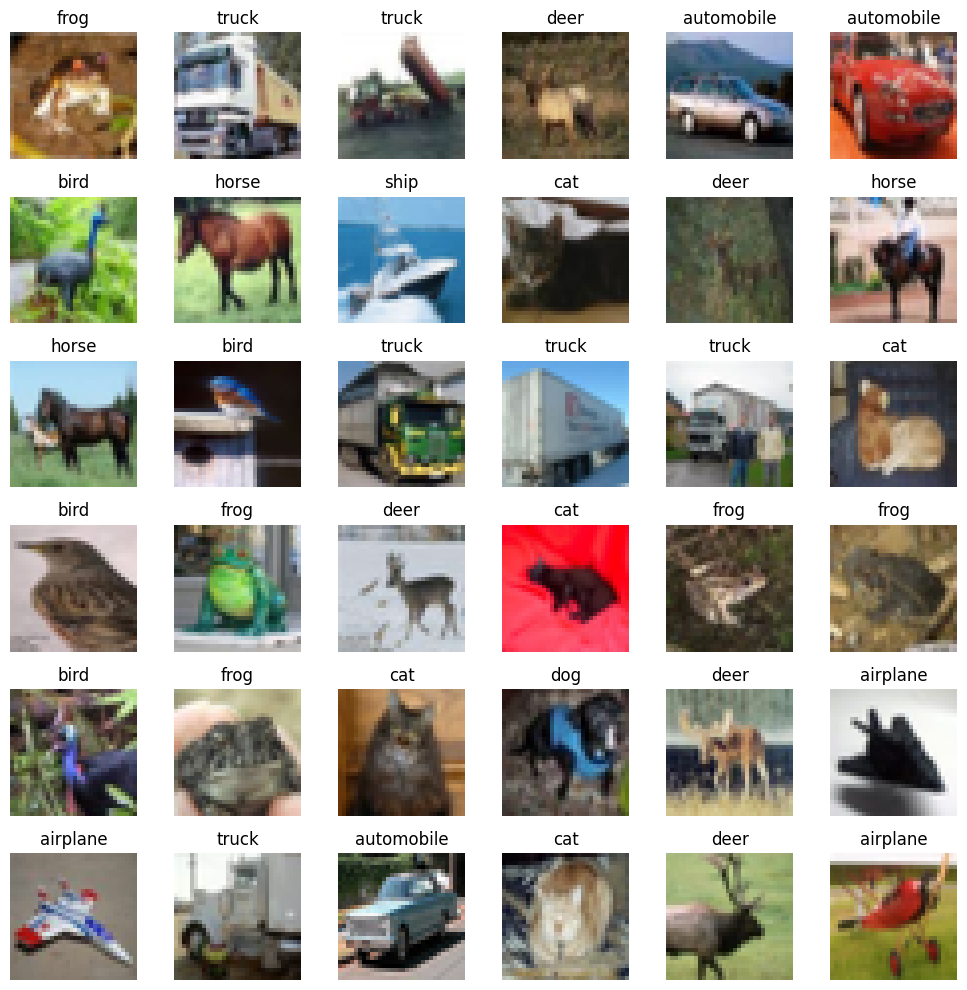

In [8]:
def visualize(loader, classes, n=64):
    # get images and labels
    imgs, labels = next(iter(loader))
    n = min(imgs.shape[0], n)

    # get subset
    imgs = imgs[:n]
    labels = labels[:n]
    
    # get row-col range
    cols = int(n**(0.5))
    rows = (n + cols - 1) // cols

    # create figure
    plt.figure(figsize=(10, 10))

    for i in range(n):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(imgs[i].permute(1, 2, 0))
        plt.title(classes[labels[i]])
        plt.axis("off")

    plt.tight_layout()
    plt.show()


visualize(train_ld, train_tn.classes, 36)

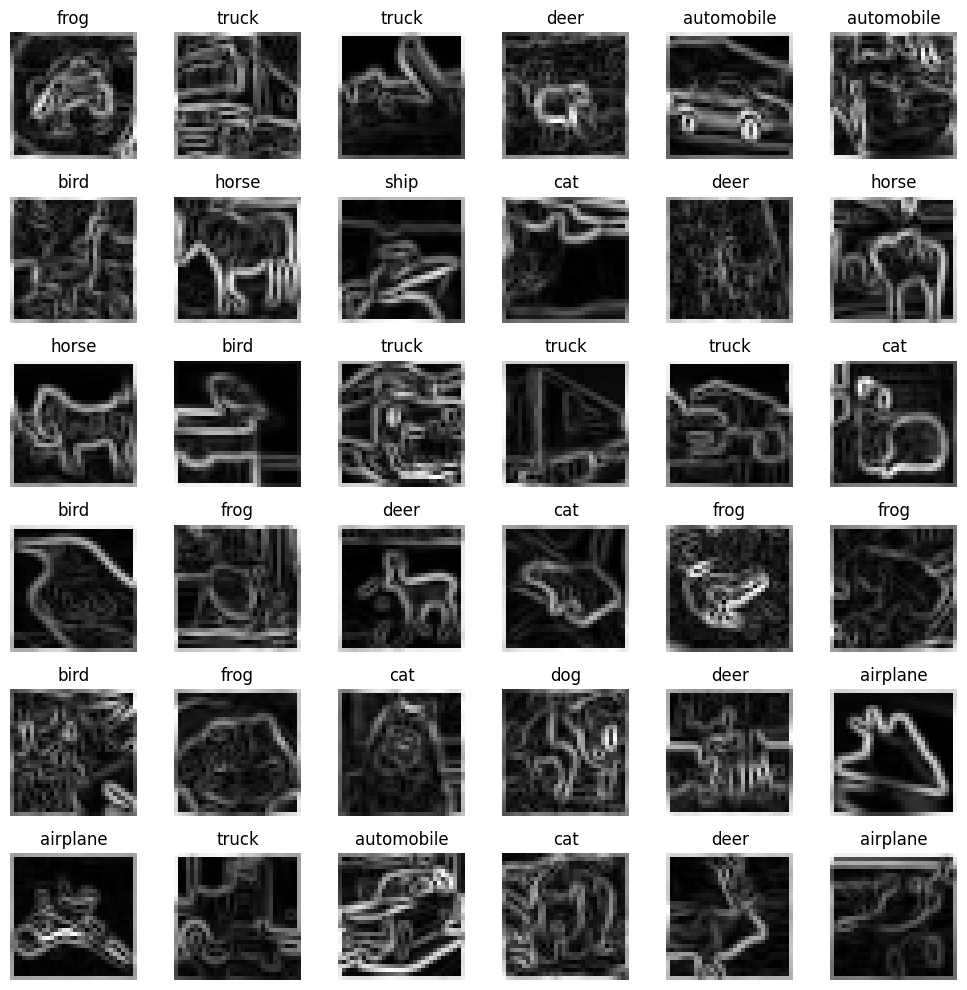

In [9]:
def visualize_sobel(loader, classes, n=64):
    imgs, labels = next(iter(loader))
    n = min(imgs.shape[0], n)
    imgs = imgs[:n]
    labels = labels[:n]


    # grayscale from PIL
    r, g, b = imgs[:, 0:1], imgs[:, 1:2], imgs[:, 2:3]
    gray = 0.299 * r + 0.587 * g + 0.114 * b

    # Sobel kernels
    sobel_x = torch.tensor([
        [-1., 0., 1.],
        [-2., 0., 2.],
        [-1., 0., 1.]
    ]).unsqueeze(0).unsqueeze(0)
    sobel_y = torch.tensor([
        [-1., -2., -1.],
        [ 0.,  0.,  0.],
        [ 1.,  2.,  1.]
    ]).unsqueeze(0).unsqueeze(0)

    # detect edge
    gx = F.conv2d(gray, sobel_x, padding=1)
    gy = F.conv2d(gray, sobel_y, padding=1)
    edges = torch.sqrt(gx ** 2 + gy ** 2)

    # normalize
    e_min, e_max = edges.min(), edges.max()
    edges = (edges - e_min) / (e_max - e_min + 1e-8)

    # Plot
    cols = int(n ** 0.5)
    rows = (n + cols - 1) // cols

    plt.figure(figsize=(10, 10))
    for i in range(n):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(edges[i, 0], cmap="gray")
        plt.title(classes[labels[i]])
        plt.axis("off")
    plt.tight_layout()
    plt.show()

visualize_sobel(train_ld, train_tn.classes, 36)

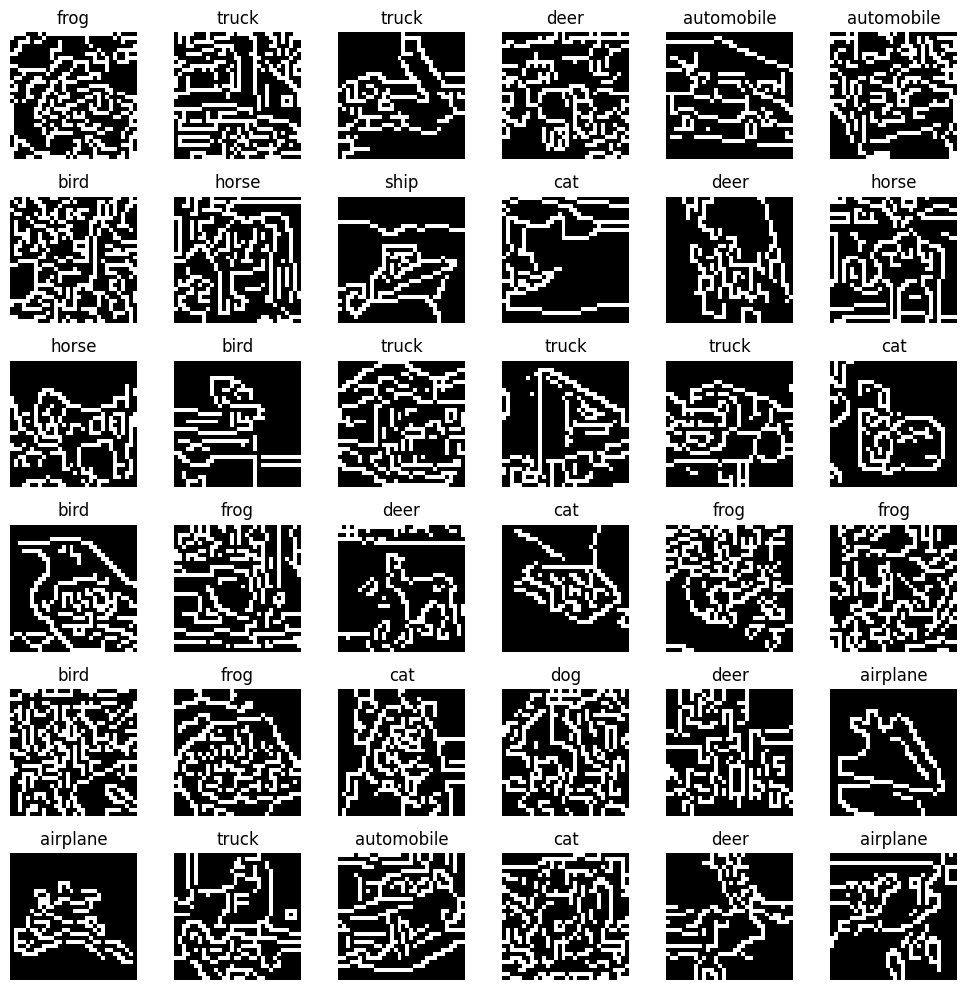

In [10]:
def visualize_canny(loader, classes, n=64):
    imgs, labels = next(iter(loader))
    n = min(imgs.shape[0], n)
    imgs = imgs[:n]
    labels = labels[:n]

    # to numpy
    imgs_np = imgs.permute(0, 2, 3, 1).numpy()
    imgs_np = (imgs_np * 255).astype("uint8")

    edges = []
    for i in range(n):
        gray = cv2.cvtColor(imgs_np[i], cv2.COLOR_RGB2GRAY)
        edge = cv2.Canny(gray, 50, 150)
        edges.append(edge)


    # Plot
    cols = int(n**0.5)
    rows = (n + cols - 1) // cols

    plt.figure(figsize=(10, 10))
    for i in range(n):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(edges[i], cmap="gray")
        plt.title(classes[labels[i]])
        plt.axis("off")

    plt.tight_layout()
    plt.show()

visualize_canny(train_ld, train_tn.classes, 36)